SOLO AÑADIR COSAS DEBAJO DEL CHUNK DE CADA NOMBRE

ESTA PARTE ES PARA JAVIER

ESTA PARTE ES PARA ALMODOVAR

ESTA PARTE ES PARA ALBERTO

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount'],
      dtype='object')
15.577018712603214 No taxes mean
16.078110822888735 Total amount mean
0.4972142408420099


payment_type
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
Name: mta_tax, dtype: object

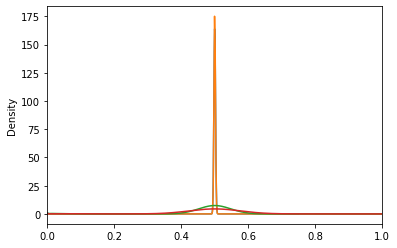

In [15]:
# 2 - Average total price per trip excluding taxes

import pandas as pd
data=pd.read_csv("C:/Users/Alberto/Desktop/Máster UC3M/3rd quarter/Computación Escalada/SDComputing_labs/LAB2/tripdata_2017-01.csv",header=0)
print (data.columns)

#We select the columns corresponding to the fare, tip, tolls and extra amount and the improvement surcharge, excluding the taxes and we add them together.

no_taxes = data['fare_amount'] + data['tip_amount'] + data['tolls_amount'] + data['extra'] + data['improvement_surcharge']

#Now, we compute the mean of this quantity. 
meanprice=no_taxes.mean()
print (meanprice, 'No taxes mean')

#Let's compare this mean value to the mean of the total amount given to the driver.

total = data['total_amount']
total_mean = total.mean()
print (total_mean, 'Total amount mean')

#We can see that there is a difference of close to 0.5$ between these amounts, meaning that the fraction of the total amount spent in taxes
#is close to 0.5$ for every trip. Let's check this fact: 
print(data['mta_tax'].mean())

#We can check how the amount paid in taxes varies in terms of the 
snd_analysis = data.loc[:,['payment_type', 'mta_tax', 'total_amount']]
snd_analysis.groupby(["payment_type"])["mta_tax"].plot(kind='density',xlim=[0,1],xlabel="Price")


In [9]:
#Now, let's implement the previous computations with pyspark. 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("prueba").master("local[*]").getOrCreate()

rdd = spark.sparkContext.parallelize(no_taxes)
from pyspark.sql.functions import mean as _mean 
totalsum rdd.sum()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 5 in stage 0.0 failed 1 times, most recent failure: Lost task 5.0 in stage 0.0 (TID 5) (DESKTOP-25CIBG5 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 14 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2261)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 14 more
